## Protein-coding paralog pairs dataset from Ensembl v93

**Input:** 
- Ensembl list of paralogs
- WGD data
- HGNC annotations

**Output:** All protein coding paralog genes & pairs with some basic annotations

Ensembl release 93: http://jul2018.archive.ensembl.org/index.html

Notes:  
- ENSEMBL paralog data is listed as symmetric paralog pairs.
- The sequence identity of a paralog pair is not symmetric because the paralogs may have different lengths. 

Ensembl Filters: 
- Paralogous Human Genes: Only --> 20385 / 64561 Genes

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import networkx as nx
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import Phylo

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_ensembl_data = get_data_path(['ensembl', '93'], 'paralog_pairs_all.txt')
file_singh_wgds = get_data_path(['WGD_sources','singh_2019'], 'hsapiens.Pairs.Strict.2R.txt')
file_makino_wgds = get_data_path(['WGD_sources'], 'makino_2010_ohnologs.xls')
file_gene_id_map = get_data_path(['HGNC'], 'hgnc_complete_set_2021-07-01.txt')

# Outputs
file_all_paralog_genes = get_local_data_path(['processed', 'ensembl_93'], 'all_paralog_genes_min20.csv')
file_unique_pairs = get_local_data_path(['processed', 'ensembl_93'], 'unique_pairs.csv')

### Protein-coding paralog pairs w/ >=20% sequence identity

In [2]:
raw_data = pd.read_csv(file_ensembl_data)
raw_data[:1]

,Gene stable ID,Human paralogue gene stable ID,Paralogue %id. target Human gene identical to query gene,Paralogue %id. query gene identical to target Human gene
0,ENSG00000276626,ENSG00000202198,53.6885,39.577


In [3]:
# Clean up column names
data = raw_data.rename(columns={
    'Gene stable ID': 'A1_ensembl',
    'Human paralogue gene stable ID': 'A2_ensembl',
    'Paralogue %id. target Human gene identical to query gene': 'seq_id',
})
data = data[['A1_ensembl','A2_ensembl','seq_id']].drop_duplicates().reset_index(drop=True)
print('N pairs:', data.shape[0], '-- N genes:', data.A1_ensembl.nunique())
data[:2]

N pairs: 3654800 -- N genes: 20385


,A1_ensembl,A2_ensembl,seq_id
0,ENSG00000276626,ENSG00000202198,53.6885
1,ENSG00000276626,ENSG00000201315,50.4098


#### Filter to protein-coding genes

In [4]:
gene_id_map = pd.read_csv(file_gene_id_map, sep='\t',low_memory=False)[['symbol','ensembl_gene_id','locus_type']]
gene_id_map = gene_id_map.dropna(subset=['ensembl_gene_id'])

# Annotate with HGNC locus type - merge on Ensembl ID
df = pd.merge(data, gene_id_map.rename(columns={'ensembl_gene_id':'A1_ensembl','symbol':'A1'}), on=['A1_ensembl'])
df = pd.merge(df, gene_id_map.rename(columns={'ensembl_gene_id':'A2_ensembl','symbol':'A2'}), on=['A2_ensembl'])
print('N pairs in HGNC:', int(df.shape[0]/2), '/', int(data.shape[0]/2))
display(df[:1])

# Only keep pairs where A1 and A2 are both protein-coding in HGNC
coding_pairs = df[(df.locus_type_x=='gene with protein product') & (df.locus_type_y=='gene with protein product')]
coding_pairs = coding_pairs.drop(columns=['locus_type_x', 'locus_type_y']).drop_duplicates().reset_index(drop=True)
print('N protein coding pairs in HGNC:', int(coding_pairs.shape[0]/2))
display(coding_pairs[:1])

# Add sorted symbol column at the front
coding_pairs = coding_pairs.assign(
    pair = coding_pairs.apply(lambda x: '_'.join(sorted([x.A1, x.A2])), axis=1))
coding_pairs = coding_pairs.loc[:, ['pair'] + coding_pairs.columns.tolist()[:-1]]
display(coding_pairs[:1])

# Expect each pair to be in the list twice
assert(coding_pairs.duplicated(subset=['pair']).sum() * 2 == coding_pairs.shape[0])

N pairs in HGNC: 1304205 / 1827400


,A1_ensembl,A2_ensembl,seq_id,A1,locus_type_x,A2,locus_type_y
0,ENSG00000201317,ENSG00000201628,65.5172,RNU4-59P,pseudogene,RNU4-7P,pseudogene


N protein coding pairs in HGNC: 41896


,A1_ensembl,A2_ensembl,seq_id,A1,A2
0,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4


,pair,A1_ensembl,A2_ensembl,seq_id,A1,A2
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4


#### Filter on sequence identity

In [5]:
# Get min/max sequence identity for each pair
coding_pairs['min_seq_id'] = coding_pairs.groupby('pair').seq_id.transform('min')
coding_pairs['max_seq_id'] = coding_pairs.groupby('pair').seq_id.transform('max')
assert(coding_pairs[(coding_pairs.seq_id!=coding_pairs.min_seq_id) & 
                    (coding_pairs.seq_id!=coding_pairs.max_seq_id)].shape[0]==0)

# Drop pairs with seq_id < 20% in either direction of comparison
paralog_pairs = coding_pairs[coding_pairs.min_seq_id>=20].reset_index(drop=True)
print('Protein coding pairs w/ >=20% sequence identity:', paralog_pairs.pair.nunique())
assert(paralog_pairs.shape[0] == paralog_pairs.pair.nunique()*2)
paralog_pairs[:1]

Protein coding pairs w/ >=20% sequence identity: 28568


,pair,A1_ensembl,A2_ensembl,seq_id,A1,A2,min_seq_id,max_seq_id
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4,28.9655,29.3023


### Add annotations
#### 1. Duplication mode - union of WGDs from two sources

In [6]:
singh_wgd = pd.read_csv(file_singh_wgds, sep='\t')
display(singh_wgd[:1])
singh_wgd = singh_wgd.assign(ensembl_ids = singh_wgd.apply(lambda x: '_'.join(sorted([x.Ohno1,x.Ohno2])), axis=1))
print('N Singh WGDs:', singh_wgd.ensembl_ids.nunique())

,Ohno1,Ohno2,Symbol1,Symbol2,Og weighted global mean,Self weighted global mean,Outgroup Support,Duplication time,Gene type
0,ENSG00000164236,ENSG00000167612,ANKRD33B,ANKRD33,0.000159,1.329170e-08,2.0,Vertebrata,protein_coding


N Singh WGDs: 4254


In [7]:
makino_wgd = pd.read_excel(file_makino_wgds, skiprows=1, skipfooter=3, sheet_name='Table S7')
display(makino_wgd[:1])
makino_wgd = makino_wgd.assign(ensembl_ids = makino_wgd.apply(lambda x: '_'.join(sorted([x.Ohnolog1,x.Ohnolog2])), axis=1))
print('N Makino WGDs:', makino_wgd.ensembl_ids.nunique())

,Ohnolog1,chr_ohno1,Position1,Ohnolog2,chr_ohno2,Position2,C_int,C_sav,Amphi,Sea_u,Fly,Worm
0,ENSG00000130762,1,3361100,ENSG00000142632,1,16411691,None,None,None,Ohno,Ohno,None


N Makino WGDs: 9057


In [8]:
# Add sorted ensembl ID column for comparisson (drop again after)
pairs_annot = paralog_pairs.assign(
    ensembl_ids = paralog_pairs.apply(lambda x: '_'.join(sorted([x.A1_ensembl,x.A2_ensembl])), axis=1))
pairs_annot = pairs_annot.assign(singh_wgd = pairs_annot.ensembl_ids.isin(singh_wgd.ensembl_ids),
                                 makino_wgd = pairs_annot.ensembl_ids.isin(makino_wgd.ensembl_ids))
pairs_annot['WGD'] = (pairs_annot.singh_wgd | pairs_annot.makino_wgd)
pairs_annot = pairs_annot.drop(columns=['ensembl_ids'])
print('N Singh WGD:', pairs_annot[pairs_annot.singh_wgd].pair.nunique())
print('N Makino WGD:', pairs_annot[pairs_annot.makino_wgd].pair.nunique())
print('N either WGD:', pairs_annot[pairs_annot.WGD].pair.nunique())
display(pairs_annot[:1])

N Singh WGD: 3632
N Makino WGD: 5897
N either WGD: 6601


,pair,A1_ensembl,A2_ensembl,seq_id,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4,28.9655,29.3023,False,True,True


#### 2. Location (Chromosome)

In [9]:
# Get gene location from HGNC
id_map = pd.read_csv(file_gene_id_map, sep='\t',low_memory=False).dropna(subset=['symbol'])[['symbol','location']]
pairs_annot2 = pd.merge(pairs_annot, id_map.rename(columns={'symbol':'A1', 'location':'A1_chr'}))
pairs_annot2 = pd.merge(pairs_annot2, id_map.rename(columns={'symbol':'A2','location':'A2_chr'}))

# Reduce location to chr number (if possible)
def get_chr(x):
    if str(x) == 'nan': return 'NA'
    res = re.search('([\dXY]+)[qp]', x)
    if not res: return x
    return res.group(1)

pairs_annot2['A1_chr'] = pairs_annot2.A1_chr.apply(get_chr)
pairs_annot2['A2_chr'] = pairs_annot2.A2_chr.apply(get_chr)

# Whether genes in pair are on same chromosome
pairs_annot2 = pairs_annot2.assign(same_chr = (pairs_annot2.A1_chr == pairs_annot2.A2_chr))
display(pairs_annot2[:2])

,pair,A1_ensembl,A2_ensembl,seq_id,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,A1_chr,A2_chr,same_chr
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4,28.9655,29.3023,False,True,True,1,2,False
1,TEKT1_TEKT4,ENSG00000167858,ENSG00000163060,37.5598,TEKT1,TEKT4,36.0920,37.5598,False,True,True,17,2,False


#### 3. Family size

In [10]:
# Set of all paralogs for each A1 (paralog pairs list is symmetric)
paralog_families = pairs_annot2.groupby('A1').agg({'A2':set}).reset_index()
paralog_families = paralog_families.rename(columns={'A1':'gene', 'A2':'paralogs'})
display(paralog_families[:1])

# Family (size) = union of all A1 and all A2 paralogs
df = pd.merge(pairs_annot2[['A1','A2']], paralog_families.rename(columns={'gene':'A1'}))
df = pd.merge(df, paralog_families.rename(columns={'gene':'A2'}), on=['A2'])
df['family'] = df.apply(lambda x: frozenset(x.paralogs_x.union(x.paralogs_y)), axis=1)
df['family_size'] = df.apply(lambda x: len(x.paralogs_x.union(x.paralogs_y)), axis=1)
df = df.drop(columns=['paralogs_x','paralogs_y'])

# Merge in family id and then merge family size and id with each pair
pairs_annot3 = pd.merge(pairs_annot2, df.drop(columns=['family']), how='left')
display(pairs_annot3[:1])

,gene,paralogs
0,A1CF,"{HNRNPR, RBM47, SYNCRIP, RBM46}"


,pair,A1_ensembl,A2_ensembl,seq_id,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,A1_chr,A2_chr,same_chr,family_size
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4,28.9655,29.3023,False,True,True,1,2,False,5


#### 4. Closest pair (highest sequence identity)
Closest pair for each A1 gene.  
NOTE that this is not neccesarily symmetric: e.g. TEKT3 is closest for TEKT4 but TEKT5 is closest for TEKT3

In [11]:
# Find highest seq id for each A1 gene
max_per_A1 = pairs_annot3.groupby('A1').seq_id.max().reset_index()
display(max_per_A1[:1])
# Merge with all pairs to find what the closest A2 for each A1 (merging on A1 and seq id pair)
pairs_annot4 = pd.merge(pairs_annot3, max_per_A1, how='left', indicator='closest')
# Annotate pairs as closest if A2 is A1's closest paralog (in terms of sequence identity)
pairs_annot4['closest'] = pairs_annot4['closest'] == 'both'
pairs_annot4[:1]

,A1,seq_id
0,A1CF,46.8439


,pair,A1_ensembl,A2_ensembl,seq_id,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,A1_chr,A2_chr,same_chr,family_size,closest
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4,28.9655,29.3023,False,True,True,1,2,False,5,False


#### 5. Add entrez id from HGNC

In [12]:
id_map = pd.read_csv(file_gene_id_map, sep='\t', low_memory=False)[['entrez_id','symbol']].dropna()

# Merge entrez ID for each gene
df = pd.merge(pairs_annot4, id_map.rename(columns={'symbol':'A1','entrez_id':'A1_entrez'}))
pairs_annot5 = pd.merge(df, id_map.rename(columns={'symbol':'A2','entrez_id':'A2_entrez'}))\
                 .astype({'A1_entrez':'int', 'A2_entrez':'int'})

print('Num pairs (min. 20%):', pairs_annot5.pair.nunique())
print('Num paralog genes (min. 20%):', pairs_annot5.A1.nunique())
display(pairs_annot5[:2])

Num pairs (min. 20%): 28568
Num paralog genes (min. 20%): 12128


,pair,A1_ensembl,A2_ensembl,seq_id,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,A1_chr,A2_chr,same_chr,family_size,closest,A1_entrez,A2_entrez
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,29.3023,TEKT2,TEKT4,28.9655,29.3023,False,True,True,1,2,False,5,False,27285,150483
1,TEKT1_TEKT4,ENSG00000167858,ENSG00000163060,37.5598,TEKT1,TEKT4,36.0920,37.5598,False,True,True,17,2,False,5,True,83659,150483


### Export data sets
#### Paralog genes

In [13]:
# List of all paralog genes, incl. sequence identity with closest paralog, whether in WGD pair, & num paralogs 
all_paralog_genes = pairs_annot5.groupby(['A1','A1_entrez'])\
                                .agg({'A2':'count', 'WGD':max, 'seq_id':max}).reset_index()
all_paralog_genes.columns = ['symbol','entrez_id','n_paralogs','WGD','max_seq_id']

assert(pd.concat([pairs_annot5.A1, pairs_annot5.A2]).nunique() == all_paralog_genes.shape[0])
print('Avg max seq id = %.2f%%' % (all_paralog_genes.max_seq_id.mean()))
print('N genes in WGD pairs: %d / %d = %.2f%%' % (sum(all_paralog_genes.WGD), all_paralog_genes.shape[0],
                                                  sum(all_paralog_genes.WGD)/all_paralog_genes.shape[0]*100))
print('N paralog genes:', all_paralog_genes.shape[0])
display(all_paralog_genes[:1])
all_paralog_genes.to_csv(file_all_paralog_genes, index=0)

Avg max seq id = 53.51%
N genes in WGD pairs: 7004 / 12128 = 57.75%
N paralog genes: 12128


,symbol,entrez_id,n_paralogs,WGD,max_seq_id
0,A1CF,29974,4,True,46.8439


#### Unique pairs
All paralog pair features here are symmetric, expect for the "closest".  
Mark a pair as closest if both genes are each other's closest paralog (min).  
For all other features min==max.

In [23]:
unique_pairs = pairs_annot5.drop(columns=['A1','A2','A1_ensembl','A2_ensembl','A1_entrez','A2_entrez','seq_id',
                                          'singh_wgd','makino_wgd','A1_chr','A2_chr'])\
                           .groupby('pair').min().reset_index()
print('N unique pairs:', unique_pairs.shape[0])
display(unique_pairs[:2])

# Add back other ids
unique_pairs[['A1','A2']] = unique_pairs['pair'].str.split('_', 1, expand=True)
unique_pairs = pd.merge(unique_pairs, pairs_annot5[['A1','A1_entrez','A1_chr']].drop_duplicates())
unique_pairs = pd.merge(unique_pairs, pairs_annot5[['A2','A2_entrez','A2_chr']].drop_duplicates())
unique_pairs = unique_pairs.astype({'A1_entrez':'int', 'A2_entrez':'int'})
unique_pairs[:2]

N unique pairs: 28568


,pair,min_seq_id,max_seq_id,WGD,same_chr,family_size,closest
0,A1CF_HNRNPR,30.9748,32.7243,False,False,5,False
1,A1CF_RBM46,43.6877,49.3433,True,False,6,False


,pair,min_seq_id,max_seq_id,WGD,same_chr,family_size,closest,A1,A2,A1_entrez,A1_chr,A2_entrez,A2_chr
0,A1CF_HNRNPR,30.9748,32.7243,False,False,5,False,A1CF,HNRNPR,29974,10,10236,1
1,A1CF_RBM46,43.6877,49.3433,True,False,6,False,A1CF,RBM46,29974,10,166863,4


In [24]:
unique_pairs.to_csv(file_unique_pairs, index=0)

#### Closest pairs

In [30]:
print('N paralog genes:', all_pairs_annot.A1.nunique())

N paralog genes: 12128


In [31]:
closest_pairs = all_pairs_annot[all_pairs_annot.closest]
# Genes with multiple closest paralogs - keep 1 at random
print('Multiple closest:', closest_pairs[closest_pairs.duplicated(subset=['A1'])].shape[0])
closest_pairs = closest_pairs.sample(frac=1) # Shuffle rows
#closest_pairs = closest_pairs.drop_duplicates(subset=['A1'], keep="first").reset_index(drop=True)
print('N closest pairs:', closest_pairs.shape[0])
closest_pairs[:2]

Multiple closest: 937
N closest pairs: 13065


,pair,A1_ensembl,A2_ensembl,seq_id,common_ancestor,A1,A2,evolutionary_distance,min_seq_id,max_seq_id,...,makino_wgd,WGD,A1_chr,A2_chr,same_chr,family_size,family_id,closest,A1_entrez,A2_entrez
32770,ALPG_ALPP,ENSG00000163286,ENSG00000163283,91.1654,Homininae,ALPG,ALPP,0.324634,90.6542,91.1654,...,False,False,2,2,True,4,2562,True,251,250
7886,ATP2C1_ATP2C2,ENSG00000064270,ENSG00000017260,62.5641,Vertebrata,ATP2C2,ATP2C1,0.176791,62.5641,62.6927,...,True,True,16,3,False,11,568,True,9914,27032


In [46]:
closest_pairs.to_csv(file_closest_pairs, index=0)

### Families

In [32]:
# Check that all families are fully connected (need unfiltered on seq id data)
G = nx.Graph()
G.add_edges_from(coding_pairs[['A1','A2']].values)
families = [f for f in nx.connected_components(G)]
for f in families:
    n = len(f)
    n_edges = G.subgraph(f).number_of_edges()
    if n*(n-1)/2 != n_edges:
        print('Not fully connect:', f)

In [33]:
def draw_family_network_for_gene(gene, G, ax):
    fam = paralog_families[paralog_families.gene==gene]
    fam_pairs = all_pairs_annot[all_pairs_annot.A1.isin(fam.paralogs.values[0])]
    G = nx.Graph()
    G.add_edges_from(fam_pairs[['A1','A2']].values)
    nx.draw_networkx(G, node_color='#f0e442', node_size=2000, ax=ax)
    ax.axis('off')
    ax.set_xlim([1.3*x for x in ax.get_xlim()])
    ax.set_ylim([1.3*y for y in ax.get_ylim()])

In [34]:
unique_pairs[unique_pairs.A1=='STAG2']

,pair,common_ancestor,evolutionary_distance,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,family_size,family_id,closest,A1,A2,A1_entrez,A1_ensembl,A1_chr,A2_entrez,A2_ensembl,A2_chr
22784,STAG2_STAG3,Vertebrata,0.176791,47.4763,49.1028,False,True,True,False,3,2561,False,STAG2,STAG3,10735,ENSG00000101972,X,10734,ENSG00000066923,7


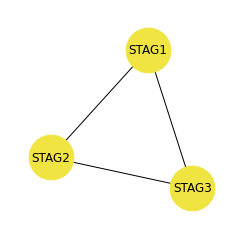

In [35]:
f, ax = plt.subplots(1, 1, figsize=(4,4))
draw_family_network_for_gene("STAG1", G, ax)
plt.savefig('../figures/stag_family.png', bbox_inches='tight', dpi=300)

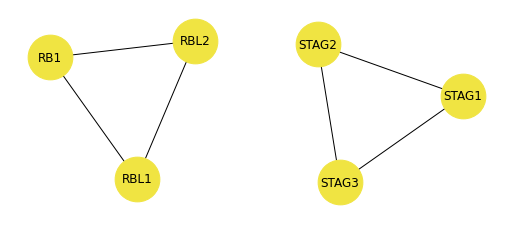

In [36]:
f, ax = plt.subplots(1, 2, figsize=(9,4))
draw_family_network_for_gene("RB1", G, ax[0])
draw_family_network_for_gene("STAG1", G, ax[1])

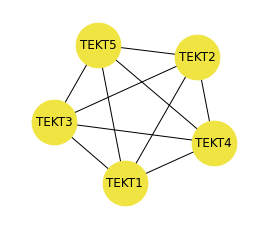

In [37]:
f, ax = plt.subplots(1, 1, figsize=(4.5,4))
draw_family_network_for_gene("TEKT1", G, ax)